In [1]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

In [2]:
def MalhaRetangular(N):
   Δ = 1.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(0.0,0.25+Δx,Δx)
   y = API_Numpy.arange(Δy,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

In [3]:
def CondiçãoInicialRayleighTaylor(X, Y, γ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.zeros(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)
   for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      if Y[i,j] < 0.5:
         R[i,j] = 2.0
         P[i,j] = 2.0*Y[i,j] + 1.0
      else:
         R[i,j] = 1.0
         P[i,j] = Y[i,j] + 1.5
         
      a = API_Numpy.sqrt(γ * P[i,j] / R[i,j])
      V[i,j] = -0.025 * a * API_Numpy.cos(8.0*API_Numpy.pi*X[i,j])

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   return Q0


In [4]:
def CondiçãoInicialRayleighTaylor_N(N, γ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialRayleighTaylor(X, Y, γ)
   return X, Y, Δ, Q0

In [5]:
def RayleighTaylorGravity(Q,API):
   g = -1.0
   # for i = 1:size(U,1)
   #    for j = 1:size(U,2)
   #       F[i,j,3] = -g * U[i,j,1]
   #       F[i,j,4] = -g * U[i,j,3]
   #    end
   # end
   Z = Q[...,0:1,:,:]*0
   F = API.concat([Z,Z,-g*Q[...,0:1,:,:],-g*Q[...,2:3,:,:]],axis=-3)
   return F

In [6]:
γ = 5.0/3.0
N = 480
x, y, Δ, U0 = CondiçãoInicialRayleighTaylor_N(N, γ)
cfl = 0.5
t_final = 1.95

In [7]:
WENO_Z_BI_sim=simulation_2D(API_Numpy,
                    euler_equation_2D,
                    WENO_Z_pm,
                    map_function=BI_mapping,
                    mapping=pre_inv_mapping)

WENO_Z_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z)

In [8]:
def RayleighTaylorGhostPointsX(Q,API):
    left=API.stack([Q[...,0,:3,:],-Q[...,1,:3,:],Q[...,2,:3,:],Q[...,3,:3,:]],axis=-3)
    left=API.reverse(left,axis=[-2])

    center=Q

    right=API.stack([Q[...,0,-3:,:],-Q[...,1,-3:,:],Q[...,2,-3:,:],Q[...,3,-3:,:]],axis=-3)
    right=API.reverse(right,axis=[-2])

    return API.concat([left,center,right],axis=-2)

def RayleighTaylorGhostPointsY(Q,API):
   raw_ref_shape=API.shape(Q)[:-3]
   out_shape=API.concat([API.shape(Q)[:-1],[3]],axis=0)
   ref_shape=API.concat([API.ones(API.shape(raw_ref_shape),dtype='int32'),[4],[1],[1]],axis=0)
   vals_left=API.reshape([2.0,0.0,0.0,1.0/(γ-1.0)],ref_shape)
   vals_right=API.reshape([1.0,0.0,0.0,2.5/(γ-1.0)],ref_shape)
   Qg = [API.ones(out_shape,'float64')*API.cast(vals_left,'float64'),
         Q,
        API.ones(out_shape,'float64')*API.cast(vals_right,'float64')]
   return API.concat(Qg,-1)

In [9]:
import seaborn
import matplotlib.pyplot as plt

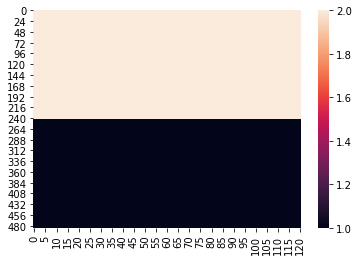

In [10]:
pre_U=RayleighTaylorGhostPointsY(U0,API_Numpy)
seaborn.heatmap(pre_U[0,:,:].T)
plt.show()

In [11]:
from IPython.display import clear_output
import dill

In [12]:
WENO_Z_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z)

WENO_Zp_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z_plus)

WENO_Z_MS_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z,
                    map_function=Hong_mapping,
                    mapping=pre_mapping)

WENO_Zp_MS_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z_plus,
                    map_function=Hong_mapping,
                    mapping=pre_mapping)

WENO_Z_BI_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z,
                    map_function=BI_mapping,
                    mapping=pre_mapping)

WENO_ZC_MS_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z_pm,
                    map_function=Hong_mapping,
                    mapping=pre_inv_mapping)

WENO_ZC_BI_sim=simulation_2D(API_TensorFlow,
                    euler_equation_2D,
                    WENO_Z_pm,
                    map_function=BI_mapping,
                    mapping=pre_inv_mapping)

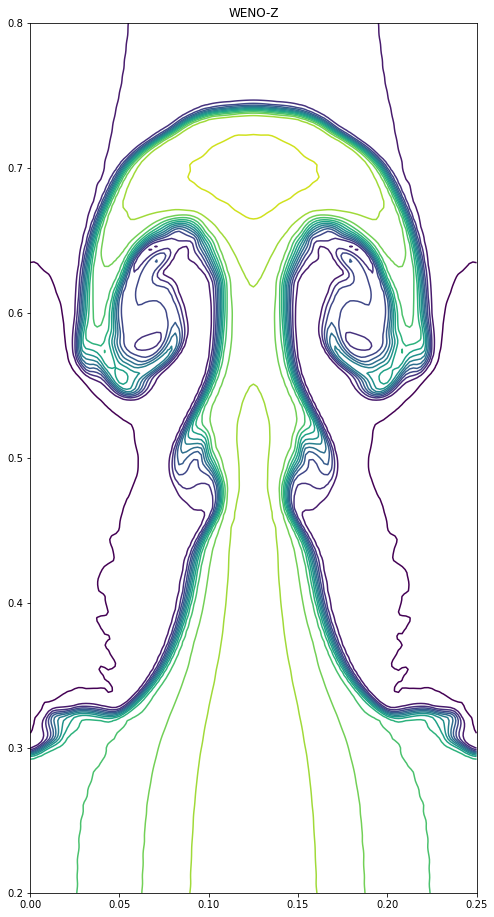

In [13]:
for WENO_type,name in zip([
    WENO_Z_sim,
    #WENO_Zp_sim,
    #WENO_Z_MS_sim,
    #WENO_Zp_MS_sim,
    #WENO_Z_BI_sim,
    #WENO_ZC_MS_sim,
    #WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    #'WENO-Z+',
    #'WENO-Z (MS)',
    #'WENO-Z+ (MS)',
    #'WENO-Z (BI)',
    #'WENO-ZC (MS)',
    #'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    while t<t_final:
        Λ  = WENO_type.equation.maximum_speed(U)
        Δt = Δ*cfl/Λ
        Δt = np.where(t+Δt>t_final,t_final-t,Δt)

        U=WENO_type.Sim_step(U, Δt, Δ, Δ, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
        t+=Δt
        print(t,end='\r')

    with open(name+'.bkp','wb') as file:
        dill.dump(U,file)

    plt.figure(figsize=(8,16))
    ref_U=U[0].numpy()
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.9,vmax=2.3)
    plt.ylim(ymin=0.2,ymax=0.8)
    plt.title(name)
    plt.savefig(name+'.png')

In [14]:
# U=U0.copy()
# for i in range(int(1.95/0.05)):
#     U=WENO_Z_sim.Sim(U, 0.05, Δ, Δ, cfl, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
#     clear_output()
#     plt.figure(figsize=(12,16))
#     ref_U=U[0].numpy()
#     seaborn.heatmap(API_Numpy.reverse(ref_U,axis=1).T)
#     plt.show()

In [15]:
import dill
with open('WENO-Z.bkp','wb') as file:
    dill.dump(U,file)

In [16]:
import dill
with open('WENO-Z.bkp','rb') as file:
    U=dill.load(file)

In [17]:
ref_U.shape

(121, 479)

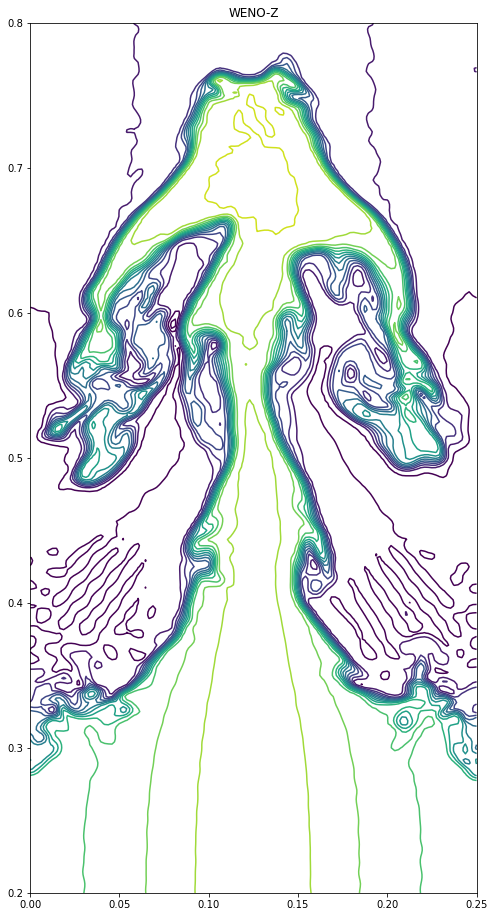

In [18]:
plt.figure(figsize=(8,16))
ref_U=U[0].numpy()
plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.9,vmax=2.3)
plt.ylim(ymin=0.2,ymax=0.8)
plt.title('WENO-Z')
plt.savefig('WENO-Z'+'.png')

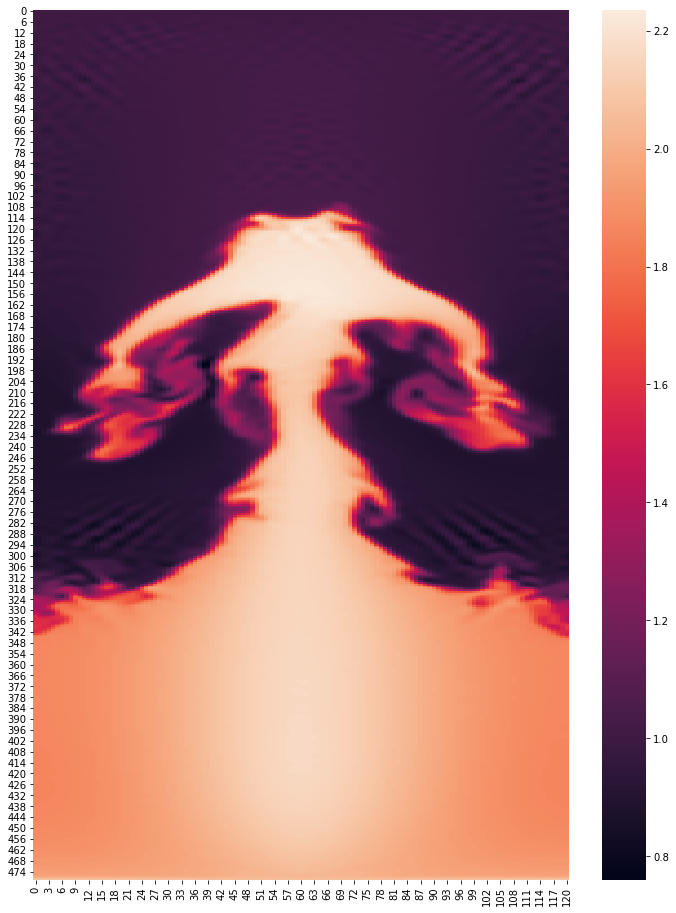

In [19]:
plt.figure(figsize=(12,16))
seaborn.heatmap(API_Numpy.reverse(U[0].numpy(),axis=1).T)
plt.show()

In [20]:
U[0]

<tf.Tensor: shape=(121, 479), dtype=float64, numpy=
array([[2.06902771, 1.99683607, 1.95240533, ..., 1.00312998, 1.00278863,
        1.00337443],
       [2.0689819 , 1.99685354, 1.95251945, ..., 1.00293685, 1.00265542,
        1.00327807],
       [2.06888812, 1.99695379, 1.95278264, ..., 1.00278271, 1.00256138,
        1.00325103],
       ...,
       [2.06899788, 1.99696849, 1.9528881 , ..., 1.00329527, 1.0027364 ,
        1.00369196],
       [2.06910439, 1.99695227, 1.95296744, ..., 1.004431  , 1.00325203,
        1.00382739],
       [2.06922981, 1.99689051, 1.95294835, ..., 1.00530156, 1.00359502,
        1.0039444 ]])>

In [21]:
U=U0.copy()
for i in range(int(1.95/0.05)):
    U=WENO_Z_BI_sim.Sim_graph(U, 0.05, Δ, Δ, cfl, RayleighTaylorGhostPointsX, RayleighTaylorGhostPointsY,RayleighTaylorGravity)
    clear_output()
    plt.figure(figsize=(12,16))
    seaborn.heatmap(U[0].T)
    plt.show()

AttributeError: 
        'EagerTensor' object has no attribute 'T'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

<Figure size 864x1152 with 0 Axes>

In [ ]:
U.shape

(4, 41, 159)